# 2D Eye-Tracking Camera Views

This notebook demonstrates 2D camera views of the eyes as seen by the eye-tracking cameras, showing pupils, corneal reflections, glints, limbus, and eyelid boundaries.

## Imports and Setup

In [ ]:
%matplotlib widget

import seet.device as device
import seet.scene as scene
import seet.user as user
import seet.visualization.scene_visualization as scene_visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import sys
sys.path.append("..")
import utils

dropdown_widget = utils.get_experiment_info(save_results=False)

RadioButtons(description='Device:', options=('default',), value='default')

## Create Scene Model

In [2]:
# Create a scene
scene_file_name, _ = \
    utils.get_configuration_files(dropdown_widget.value)  # type: ignore

et_scene = scene.SceneModel(parameter_file_name=scene_file_name)

print(f"Scene loaded from: {scene_file_name}")
print(f"Number of eyes: {len(et_scene.user.eyes)}")
print(f"Number of subsystems: {len(et_scene.device.subsystems)}")

Scene loaded from: C:\Users\padossa\repos\seet-1\seet\scene\default_scene/default_scene.json
Number of eyes: 2
Number of subsystems: 2


## 2D Camera Views

Display the eyes as observed by the eye-tracking cameras, similar to what the actual cameras would see.

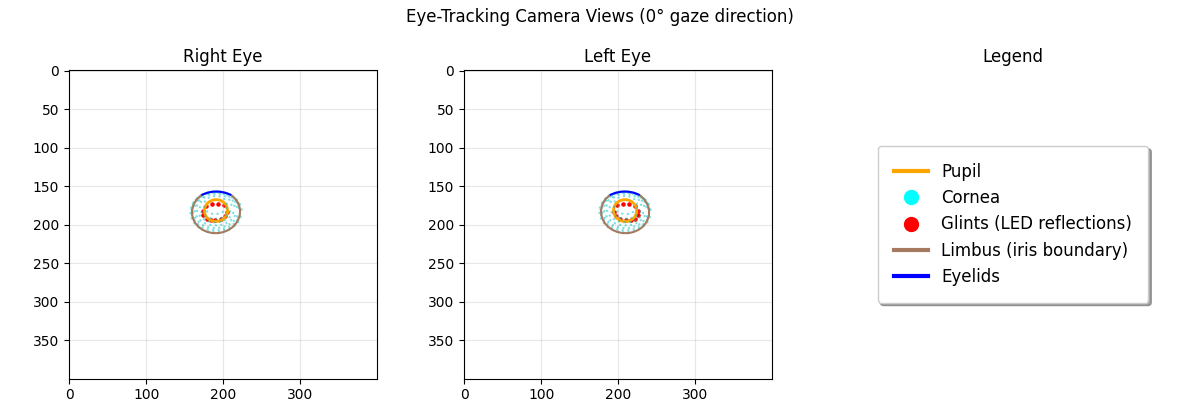

2D camera views with corrected legend colors:
- Pupil
- Cornea
- Glints (LED reflections)
- Limbus (iris boundary)
- Eyelids

Legend colors updated to match actual visualization:
- Pupil: Orange curve
- Cornea: Cyan dots
- Glints: Red dots
- Limbus: Brown curve
- Eyelids: Blue curve


In [3]:
# Setup for 2D camera views
subsystem_index = 0
camera_index = 0

subsystem = et_scene.device.subsystems[subsystem_index]
camera = subsystem.cameras[camera_index]
resolution = camera.resolution.clone().detach().numpy()

# Gaze angles (0 degrees for straight ahead)
angles_deg = torch.tensor((0.0, 0.0))

# Calculate figure size based on camera resolution
figsize = np.array([2, 1]) * resolution
height_in = 8
figsize = [height_in, height_in * figsize[1] / figsize[0]]

# Create subplot with 3 panels: Left Eye, Right Eye, and Legend
titles = ("Left Eye", "Right Eye", "Legend")
fig_2d, axs_2d = plt.subplots(nrows=1, ncols=3, figsize=(figsize[0] * 1.5, figsize[1]))
plt.suptitle("Eye-Tracking Camera Views (0° gaze direction)")

# Store legend information
legend_elements = []
legend_labels = []

# Visualize each eye and extract actual colors/styles
for i in range(2):
    eye = et_scene.user.eyes[i]
    eye.rotate_from_gaze_angles_inParent(angles_deg)

    ax = axs_2d[1 - i]  # Flip order for intuitive left/right display
    ax.set_title(titles[i])
    ax.grid(True, alpha=0.3)
    
    # Create image visualization for this subsystem
    et_image_visualization = \
        scene_visualization.ImageVisualization(
            et_scene, ax, subsystem_index=i
        )

    # Visualize different eye features
    et_image_visualization.visualize_refracted_pupil()
    et_image_visualization.visualize_cornea()
    et_image_visualization.visualize_glints()
    et_image_visualization.visualize_limbus()
    et_image_visualization.visualize_eyelids()
    
    # Extract legend elements only from the first eye to avoid duplicates
    if i == 0:
        # Get actual colors from the plotted elements by examining the axes children
        plotted_elements = ax.get_children()
        
        # Pupil - orange curve (Line2D objects)
        pupil_color = 'orange'  # Default, will be updated if found
        for element in plotted_elements:
            if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                color = element.get_color()
                if isinstance(color, str) and ('orange' in color.lower() or color.startswith('#ff') or color.startswith('#f')):
                    pupil_color = color
                    break
        legend_elements.append(plt.Line2D([0], [0], color=pupil_color, linewidth=3))
        legend_labels.append('Pupil')
        
        # Cornea - cyan dots (scatter plot or Line2D with markers)
        cornea_color = 'cyan'  # Based on your description
        for element in plotted_elements:
            if hasattr(element, 'get_facecolor') or hasattr(element, 'get_color'):
                if hasattr(element, 'get_facecolor'):
                    colors = element.get_facecolor()
                    if hasattr(colors, '__len__') and len(colors) > 0:
                        color = colors[0] if hasattr(colors[0], '__len__') else colors
                        # Check if it's cyan-ish
                        if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                            if color[0] < 0.5 and color[1] > 0.5 and color[2] > 0.5:  # Cyan-ish RGB
                                cornea_color = color
                                break
        legend_elements.append(plt.Line2D([0], [0], marker='o', color=cornea_color, 
                                        linewidth=0, markersize=10))
        legend_labels.append('Cornea')
            
        # Glints - red dots (already correct)
        glint_color = 'red'
        legend_elements.append(plt.Line2D([0], [0], marker='o', color=glint_color, 
                                        linewidth=0, markersize=10))
        legend_labels.append('Glints (LED reflections)')
            
        # Limbus - brownish curve
        limbus_color = 'brown'  # Based on your description
        for element in plotted_elements:
            if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                color = element.get_color()
                if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                    # Check if it's brownish (higher red, medium green, low blue)
                    if color[0] > 0.4 and color[1] > 0.2 and color[1] < 0.6 and color[2] < 0.4:
                        limbus_color = color
                        break
                elif isinstance(color, str) and ('brown' in color.lower() or color.startswith('#8') or color.startswith('#a')):
                    limbus_color = color
                    break
        legend_elements.append(plt.Line2D([0], [0], color=limbus_color, linewidth=3))
        legend_labels.append('Limbus (iris boundary)')
            
        # Eyelids - blue curve
        eyelids_color = 'blue'  # Based on your description
        for element in plotted_elements:
            if hasattr(element, 'get_color') and hasattr(element, 'get_linestyle'):
                color = element.get_color()
                if isinstance(color, (list, tuple, np.ndarray)) and len(color) >= 3:
                    # Check if it's blue (low red, low green, high blue)
                    if color[0] < 0.3 and color[1] < 0.3 and color[2] > 0.5:
                        eyelids_color = color
                        break
                elif isinstance(color, str) and ('blue' in color.lower() or color == 'b'):
                    eyelids_color = color
                    break
        legend_elements.append(plt.Line2D([0], [0], color=eyelids_color, linewidth=3))
        legend_labels.append('Eyelids')

    # Reset eye rotation
    eye.unrotate_from_gaze_angles_inParent(angles_deg)

# Create dedicated legend panel
legend_ax = axs_2d[2]
legend_ax.set_title("Legend")
legend_ax.axis('off')  # Turn off axes for legend panel

# Add legend to the dedicated panel
if legend_elements:
    legend_ax.legend(legend_elements, legend_labels, 
                    loc='center', fontsize=12, frameon=True, 
                    fancybox=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.show()

print("2D camera views with corrected legend colors:")
for label in legend_labels:
    print(f"- {label}")
print("\nLegend colors updated to match actual visualization:")
print("- Pupil: Orange curve")
print("- Cornea: Cyan dots") 
print("- Glints: Red dots")
print("- Limbus: Brown curve")
print("- Eyelids: Blue curve")